In [ ]:
import json
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
from auxiliaryrev import loadData_staticTargetAddrMatch

json_file = "../../experiments/exp002_20240907_sna_kadirburak/data-tshark/data_nosnap.json"
with open(json_file) as f:
    data = json.load(f)

# filter data by unique source addresses and get lists

In [ ]:
lo_uniqueSAs = []
lo_freqs     = []
lo_SActrs    = []
lo_SSIDs     = []
for pkt in data:
    if(pkt["_source"]["layers"]["wlan.sa"] not in lo_uniqueSAs):
        lo_uniqueSAs.append(pkt["_source"]["layers"]["wlan.sa"])
        lo_freqs.append(pkt["_source"]["layers"]["wlan_radio.frequency"][0])
        lo_SActrs.append(1)
        lo_SSIDs.append(pkt["_source"]["layers"]["wlan.ssid"][0])
    else:
        position_of_uniqueSA_in_listofuniqueSAs = lo_uniqueSAs.index(pkt["_source"]["layers"]["wlan.sa"])
        lo_SActrs[position_of_uniqueSA_in_listofuniqueSAs] += 1

# per-SSID statistics


In [ ]:
print("SSID | Source Address    |  Freq |  # of occurrences")
print("-"*50)
KU_AP_idx = []
for i, ssid in enumerate(lo_SSIDs):
    if ssid == "KU":
        print(ssid, "  |", lo_uniqueSAs[i][0], "| ", lo_freqs[i], "| ", lo_SActrs[i])
        KU_AP_idx.append(i)


SSID | Source Address    |  Freq |  # of occurrences
--------------------------------------------------
KU   | 4c:77:6d:05:a4:00 |  2412 |  863
KU   | 4c:77:6d:96:5b:20 |  2412 |  871
KU   | 4c:77:6d:a0:44:60 |  2412 |  585
KU   | 4c:77:6d:5f:da:c0 |  2412 |  799
KU   | 4c:77:6d:5f:ea:e0 |  2437 |  885
KU   | 4c:77:6d:92:b3:60 |  2437 |  883
KU   | 00:fc:ba:7e:0d:e0 |  2437 |  3
KU   | 4c:77:6d:05:af:20 |  2462 |  878
KU   | 4c:77:6d:a0:45:c0 |  2462 |  894
KU   | 4c:77:6d:5f:e1:e0 |  2462 |  479
KU   | 4c:77:6d:9d:e7:e0 |  2412 |  152
KU   | 4c:77:6d:93:1d:21 |  2412 |  272
KU   | b4:de:31:f5:7e:00 |  2412 |  275
KU   | 4c:77:6d:9d:ea:e0 |  2437 |  239
KU   | 20:a5:cb:c8:d5:5d |  2437 |  6
KU   | 0e:8a:ef:72:fc:b5 |  2437 |  11
KU   | 4c:77:6d:96:88:60 |  2412 |  6


In [ ]:
KU_AP_idx

[0, 3, 7, 8, 14, 17, 20, 23, 25, 28, 31, 33, 39, 40, 47, 48, 49]

# plotting SSID occurrences

In [ ]:
def frametime2secs(frametime):
    hrs   = int(frametime.split(":")[0])
    mins  = int(frametime.split(":")[1])
    secs  = int((frametime.split(":")[2]).split(".")[0])
    msecs = int((frametime.split(":")[2]).split(".")[1])
    total_seconds = (hrs*60*60*1000 + mins*60*1000 + secs*1000 + msecs*10) / 1000.0
    return total_seconds

def get_timeinsecs(sampledict, offset=0):
    return frametime2secs(sampledict["_source"]["layers"]["frame.time"][0]) - offset;

def get_freq(sampledict):
    return sampledict["_source"]["layers"]["wlan_radio.frequency"][0]

def get_sourceaddr(sampledict):
    return sampledict["_source"]["layers"]["wlan.sa"]

def get_ssid(sampledict):
    return sampledict["_source"]["layers"]["wlan.ssid"][0]

def get_rss(sampledict):
    return sampledict["_source"]["layers"]["wlan_radio.signal_dbm"][0]

In [ ]:
print(get_timeinsecs(data[1], offset=64999.800))
print(get_freq(data[1]))
print(get_sourceaddr(data[1])[0])
print(get_ssid(data[1]))
print(get_rss(data[1]))

3.2999999999956344
2412
4c:77:6d:05:a4:01
GUEST
-83


In [ ]:
time = []
for sample in data:
    t = get_timeinsecs(sample, offset=64999.800)
    if(t not in time):
        time.append(t)

In [ ]:
KU_AP_idx_filtered = [KU_AP_idx[i] for i in [4,5,8]]

In [ ]:
KU_AP_idx_filtered

[14, 17, 25]

In [ ]:
array_ssid_rss = np.zeros((len(time), len(KU_AP_idx_filtered)))*np.nan
for sample in data:
    t_sample  = get_timeinsecs(sample, offset=64999.800)
    t_idx     = time.index(t_sample)
    sa_sample = get_sourceaddr(sample)
    sa_idx    = lo_uniqueSAs.index(sa_sample)
    if(sa_idx in KU_AP_idx_filtered):
        array_ssid_idx = KU_AP_idx_filtered.index(sa_idx)
        array_ssid_rss[t_idx, array_ssid_idx] = get_rss(sample)

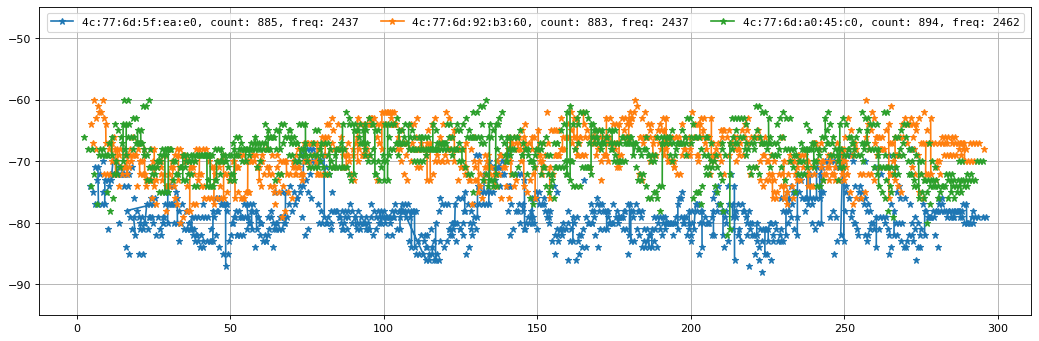

In [ ]:
plt.figure(figsize=(16, 5), dpi=80)
plt.plot(time, array_ssid_rss, marker="*");
plt.ylim([-95, -45])
plt.grid()
plt.legend([(lo_uniqueSAs[idx][0]+ ", count: " + str(lo_SActrs[idx]) + ", freq: " + str(lo_freqs[idx])) for idx in KU_AP_idx_filtered],
           prop=font_manager.FontProperties(family='monospace'), loc='upper center', ncol=3)

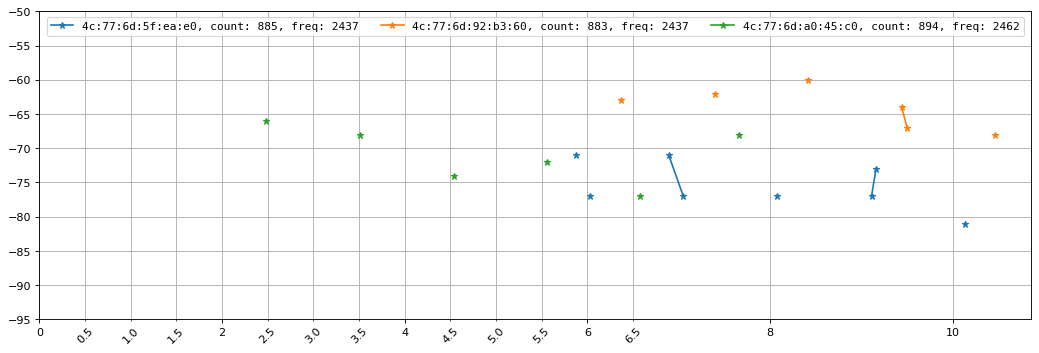

In [ ]:
fig = plt.figure(figsize=(16, 5), dpi=80)
ax  = fig.add_subplot(1, 1, 1)
cutout = 100
ax.plot(time[:cutout], array_ssid_rss[:cutout], marker="*");
ax.set_ylim([-95, -50])
ax.set_xticks(np.linspace(0,int(time[cutout]) - 1/2,int(time[cutout])*2), minor=True)
ax.set_xticklabels(np.linspace(0,int(time[cutout]) - 1/2,int(time[cutout])*2), minor=True, rotation=45)
ax.grid(which='both')
ax.legend([(lo_uniqueSAs[idx][0]+ ", count: " + str(lo_SActrs[idx]) + ", freq: " + str(lo_freqs[idx])) for idx in KU_AP_idx_filtered],
           prop=font_manager.FontProperties(family='monospace'), loc='upper center', ncol=3)


# Output of loadData function

In [ ]:
timedata, inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch("data_nosnap.json", target_addresses = ["4c:77:6d:92:b3:60", "4c:77:6d:5f:ea:e0", "4c:77:6d:a0:45:c0"])

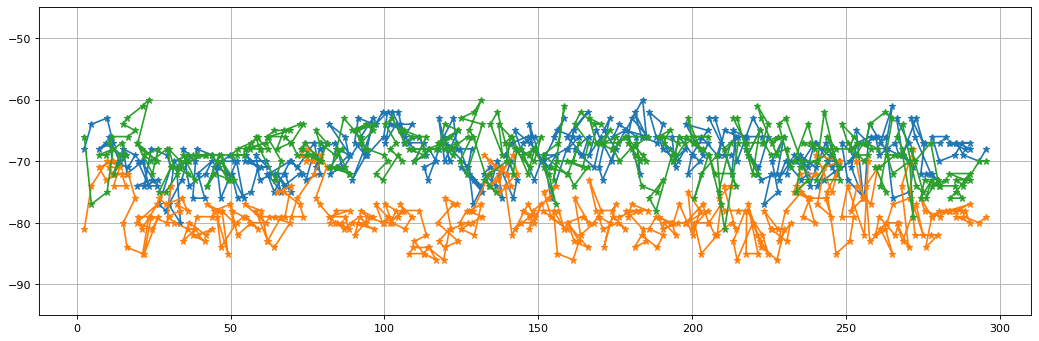

In [ ]:
plt.figure(figsize=(16, 5), dpi=80)
plt.plot(timedata, inp_rss_vals, marker="*");
plt.ylim([-95, -45])
plt.grid()

In [ ]:
len(time), len(timedata)
time[-1],timedata[-1]

(288.6100000000006, 295.50999999999476)

# Comparision of both plot

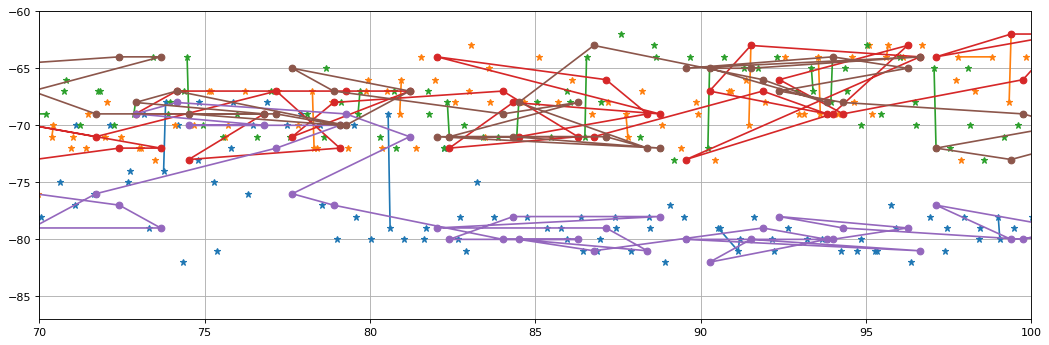

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), dpi=80)
xlim1 = 70
xlim2 = 100

ax.plot(time, array_ssid_rss, marker="*", label='Plot 1')
ax.plot(timedata, inp_rss_vals, marker="o", label='Plot 2')
# Set the limits for the y-axis
ax.set_ylim([-87, -60])
ax.set_xlim([xlim1,xlim2])
ax.grid(which='both')


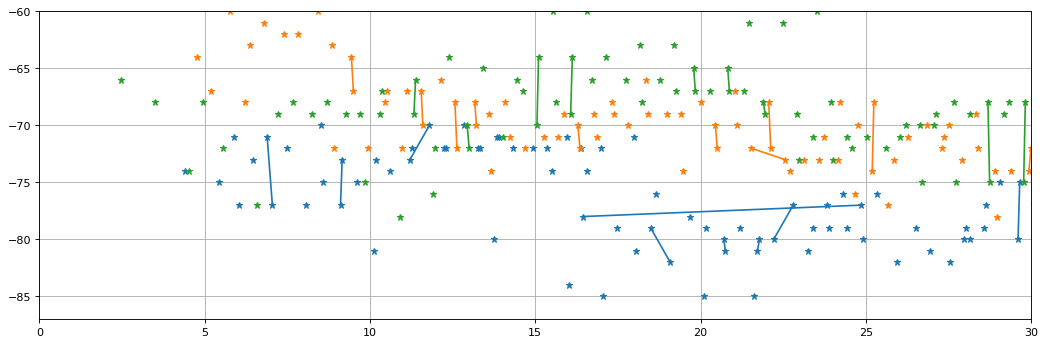

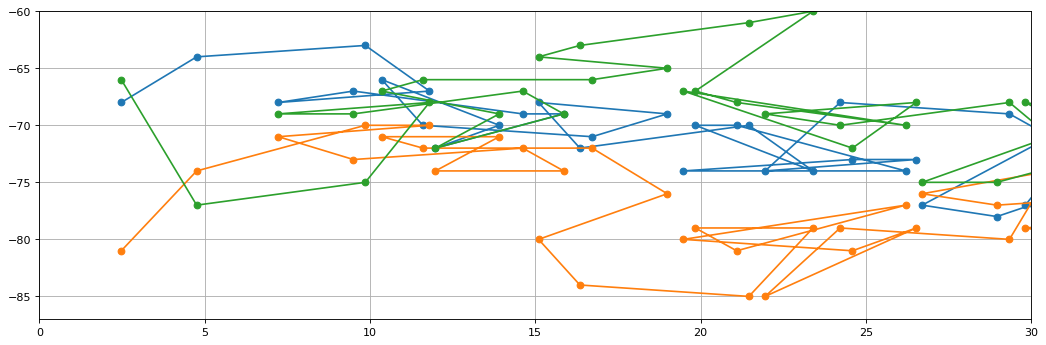

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), dpi=80)
xlim1 = 0
xlim2 = 30
# Plot 1
ax.plot(time, array_ssid_rss, marker="*", label='Plot 1')
ax.set_ylim([-87, -60])
ax.set_xlim([xlim1,xlim2])
ax.grid(which='both')
# Plot 2
fig, ax = plt.subplots(figsize=(16, 5), dpi=80)
ax.plot(timedata, inp_rss_vals, marker="o", label='Plot 2')

# Set the limits for the y-axis
ax.set_ylim([-87, -60])
ax.set_xlim([xlim1,xlim2])
ax.grid(which='both')


In [ ]:
len(inp_rss_vals)

360